#Prepare the tools

## Installing Yahoo finance

In [68]:
!pip install yfinance

## Installation of dependence

In [69]:
import yfinance as yf
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import re
import random as rn
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from statsmodels.graphics.tsaplots import plot_acf
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from keras.models import Sequential
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
import tensorflow as tf
import json
import os


from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


yf.pdr_override()


In [70]:
# reproducibly using Keras
def setup_reproducibility():
    try:
        # %tensorflow_version only exists in Colab.
        %tensorflow_version 2.x
    except Exception:
        pass

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.
    np.random.seed(42)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    rn.seed(12345)

    # Force TensorFlow to use a single thread.
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    tf.compat.v1.set_random_seed(1234)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

# Call the function to set up reproducibility



# Preparation of the datasets

In [71]:

# List of company stock symbols to download data for
company_share_list = ['AMZN', 'GOOG', 'META', 'TSLA']

# Get the current date and time
end_time = datetime.now()

# Calculate the start date as 10 years ago from the current date
start = datetime(end_time.year - 10, end_time.month, end_time.day)

# Download historical stock data for each company in the list
for stock in company_share_list:
    # Create a variable with the company stock symbol and download data
    globals()[stock] = yf.download(stock, start, end_time)

# Create a list of dataframes for each company
company_list = [AMZN, GOOG, META, TSLA]

# Corresponding names for each company
company_name = ['AMAZON', 'GOOGLE', 'META', 'TESLA']

# Assign the company name to each dataframe
for name, common_name in zip(company_list, company_name):
    name["company_name"] = common_name

# Concatenate the dataframes vertically to create a single dataframe
df = pd.concat(company_list, axis=0)

# Display the last 10 rows of the concatenated dataframe
df.tail(10)




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-09-11,264.269989,274.850006,260.609985,273.579987,273.579987,174667900,TESLA
2023-09-12,270.760010,278.390015,266.600006,267.480011,267.480011,135999900,TESLA
2023-09-13,270.070007,274.980011,268.100006,271.299988,271.299988,111673700,TESLA
2023-09-14,271.320007,276.709991,270.420013,276.040009,276.040009,107709800,TESLA
2023-09-15,277.549988,278.980011,271.000000,274.390015,274.390015,133422800,TESLA
2023-09-18,271.160004,271.440002,263.760010,265.279999,265.279999,101543300,TESLA
2023-09-19,264.350006,267.850006,261.200012,266.500000,266.500000,103704000,TESLA
2023-09-20,267.040009,273.929993,262.459991,262.589996,262.589996,122514600,TESLA
2023-09-21,257.850006,260.859985,254.210007,255.699997,255.699997,119531000,TESLA


## Lets check our datasets how they look like

In [72]:
df.head()
print(df[:2518])

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-09-23   15.700500   15.795000   15.438500   15.574500   15.574500   
2013-09-24   15.621500   15.904000   15.564000   15.706500   15.706500   
2013-09-25   15.726500   15.835500   15.537500   15.632500   15.632500   
2013-09-26   15.695000   15.968500   15.663000   15.906000   15.906000   
2013-09-27   15.846000   15.860500   15.667500   15.800500   15.800500   
...                ...         ...         ...         ...         ...   
2023-09-18  140.479996  141.750000  139.220001  139.979996  139.979996   
2023-09-19  138.699997  138.839996  135.559998  137.630005  137.630005   
2023-09-20  138.550003  139.369995  135.199997  135.289993  135.289993   
2023-09-21  131.940002  132.240005  129.309998  129.330002  129.330002   
2023-09-22  131.110001  132.029999  128.520004  129.119995  129.119995   

              Volume company_name  
D

## Putting extra information in datasets

In [73]:
# Loop through each company name
for target_company in company_name:
    # Check if the current target company is "AMAZON"
    if target_company == "AMAZON":
        # Filter the dataframe to select rows where the 'company_name' column matches "AMAZON"
        df_amaz = df[df['company_name'] == target_company]

    # Check if the current target company is "GOOGLE"
    if target_company == "GOOGLE":
        # Filter the dataframe to select rows where the 'company_name' column matches "GOOGLE"
        df_googl = df[df['company_name'] == target_company]

    # Check if the current target company is "META"
    if target_company == "META":
        # Filter the dataframe to select rows where the 'company_name' column matches "META"
        df_meta = df[df['company_name'] == target_company]

    # Check if the current target company is "TESLA"
    if target_company == "TESLA":
        # Filter the dataframe to select rows where the 'company_name' column matches "TESLA"
        df_tsla = df[df['company_name'] == target_company]

## Cleaning and handling missing values

In [74]:

# Cleaning al datesets
# Handling missing values

data_sets = [df_amaz, df_googl, df_meta, df_tsla]

def analyze_datasets(data_sets):
    for dset in data_sets:
        has_duplicates = dset.duplicated().any()
        nan_count = dset.isna().sum()
        print(nan_count)

        if has_duplicates:
            print("Dataset contains duplicate values")
        else:
            print("Dataset does not contain duplicate values")

        # Handling missing values
        dset.dropna(inplace=True)

analyze_datasets(data_sets)

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64
Dataset does not contain duplicate values
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64
Dataset does not contain duplicate values
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64
Dataset does not contain duplicate values
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
company_name    0
dtype: int64
Dataset does not contain duplicate values


In [75]:
df_tsla

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2013-09-23,12.298667,12.365333,11.807333,12.074000,12.074000,122601000,TESLA
2013-09-24,11.942667,12.330667,11.843333,12.155333,12.155333,94101000,TESLA
2013-09-25,12.237333,12.420000,12.033333,12.349333,12.349333,123790500,TESLA
2013-09-26,12.446667,12.645333,12.374000,12.576000,12.576000,99216000,TESLA
2013-09-27,12.501333,12.752000,12.428667,12.726667,12.726667,88746000,TESLA
...,...,...,...,...,...,...,...
2023-09-18,271.160004,271.440002,263.760010,265.279999,265.279999,101543300,TESLA
2023-09-19,264.350006,267.850006,261.200012,266.500000,266.500000,103704000,TESLA
2023-09-20,267.040009,273.929993,262.459991,262.589996,262.589996,122514600,TESLA


In [76]:
df_amaz.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-09-18,140.479996,141.750000,139.220001,139.979996,139.979996,42823500,AMAZON
2023-09-19,138.699997,138.839996,135.559998,137.630005,137.630005,61482500,AMAZON
2023-09-20,138.550003,139.369995,135.199997,135.289993,135.289993,46263700,AMAZON
2023-09-21,131.940002,132.240005,129.309998,129.330002,129.330002,70234800,AMAZON
2023-09-22,131.110001,132.029999,128.520004,129.119995,129.119995,51903976,AMAZON


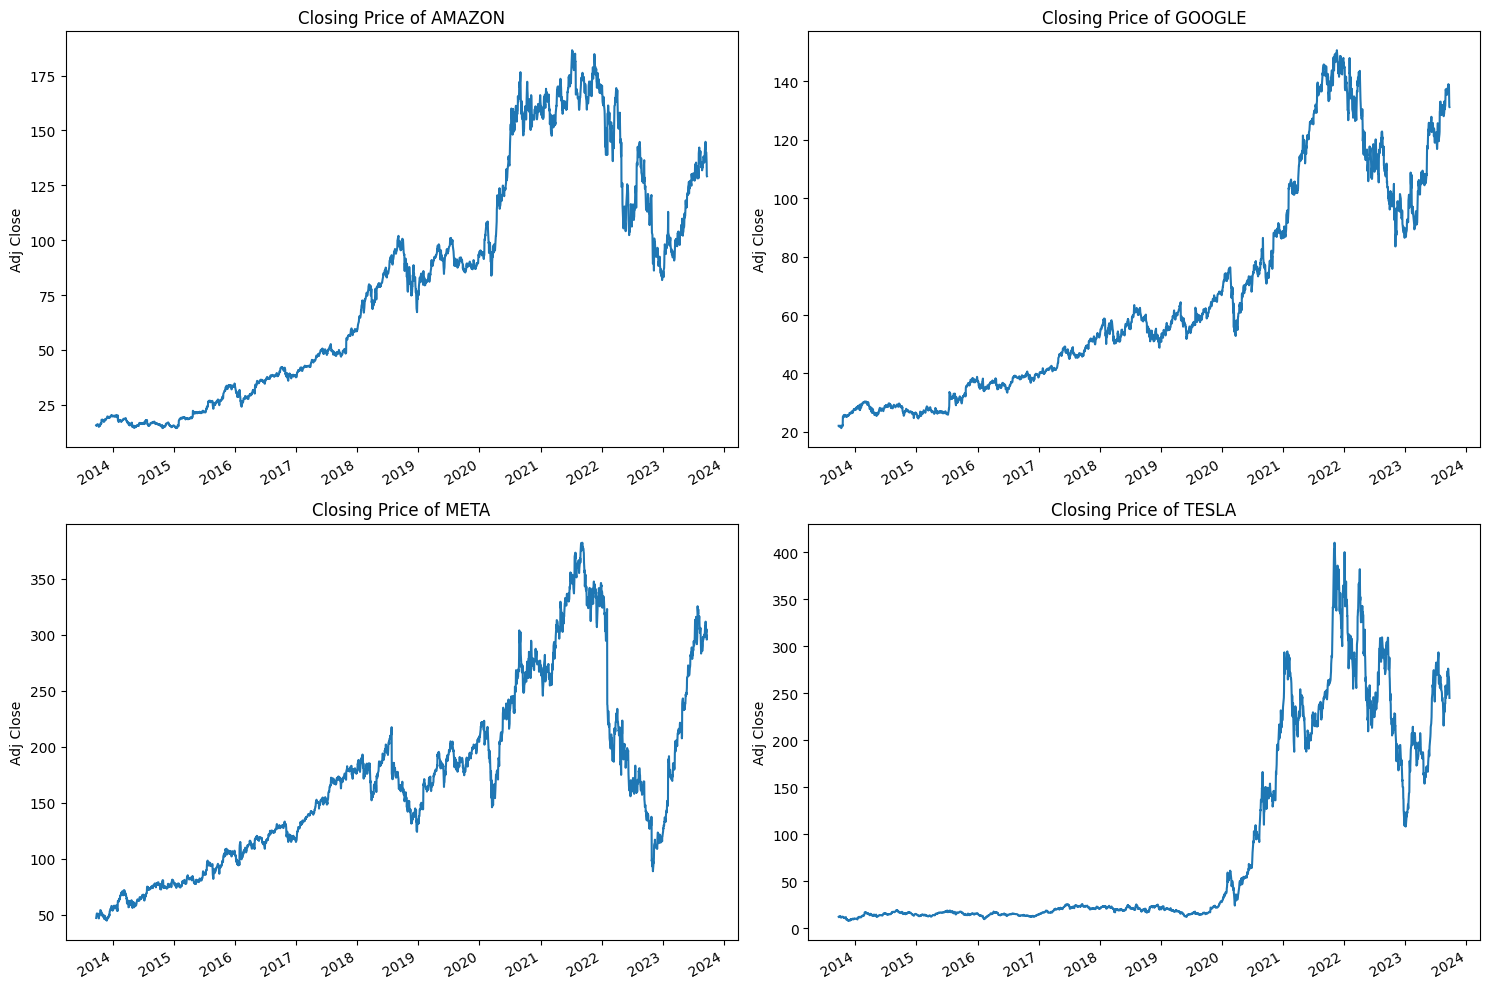

In [77]:
# ploting the all four datasets closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Looping over the all companies
for i, company in enumerate(company_list, 1):
  plt.subplot(2,2,i)
  company['Adj Close'].plot()
  plt.ylabel('Adj Close')
  plt.xlabel(None)
  plt.title(f"Closing Price of {company_name[i-1]}")

plt.tight_layout()

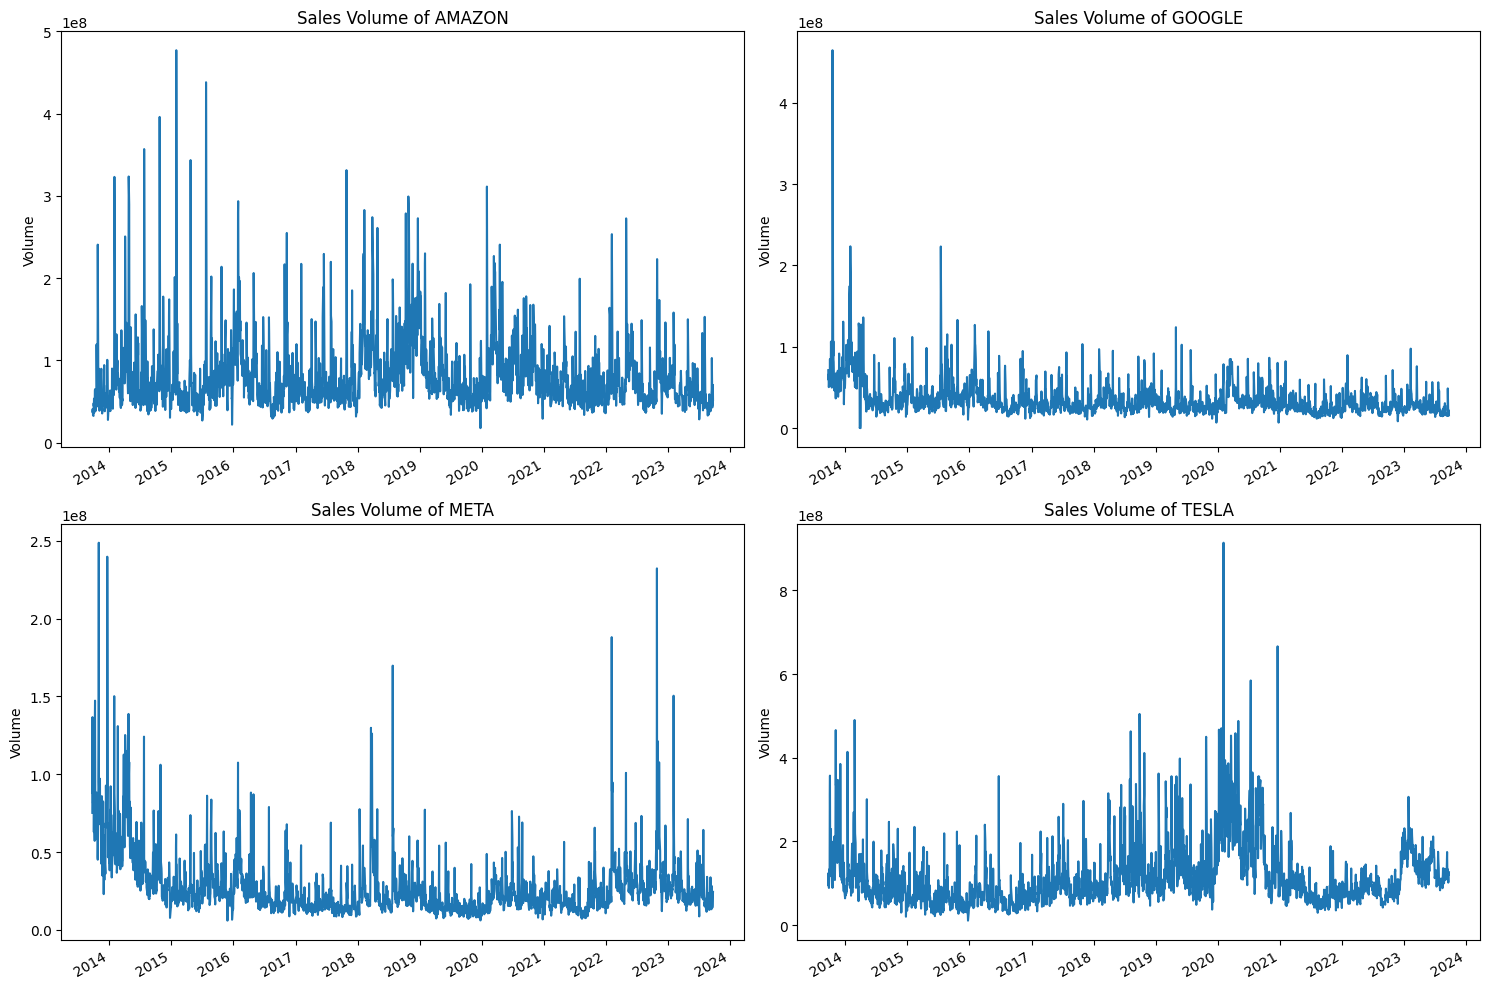

In [78]:
# ploting the all four datasets Sales volume day per day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Looping over the all companies
for i, company in enumerate(company_list, 1):
  plt.subplot(2,2,i)
  company['Volume'].plot()
  plt.ylabel('Volume')
  plt.xlabel(None)
  plt.title(f"Sales Volume of {company_name[i-1]}")

plt.tight_layout()

## Average moving trend for understanding out datasets better

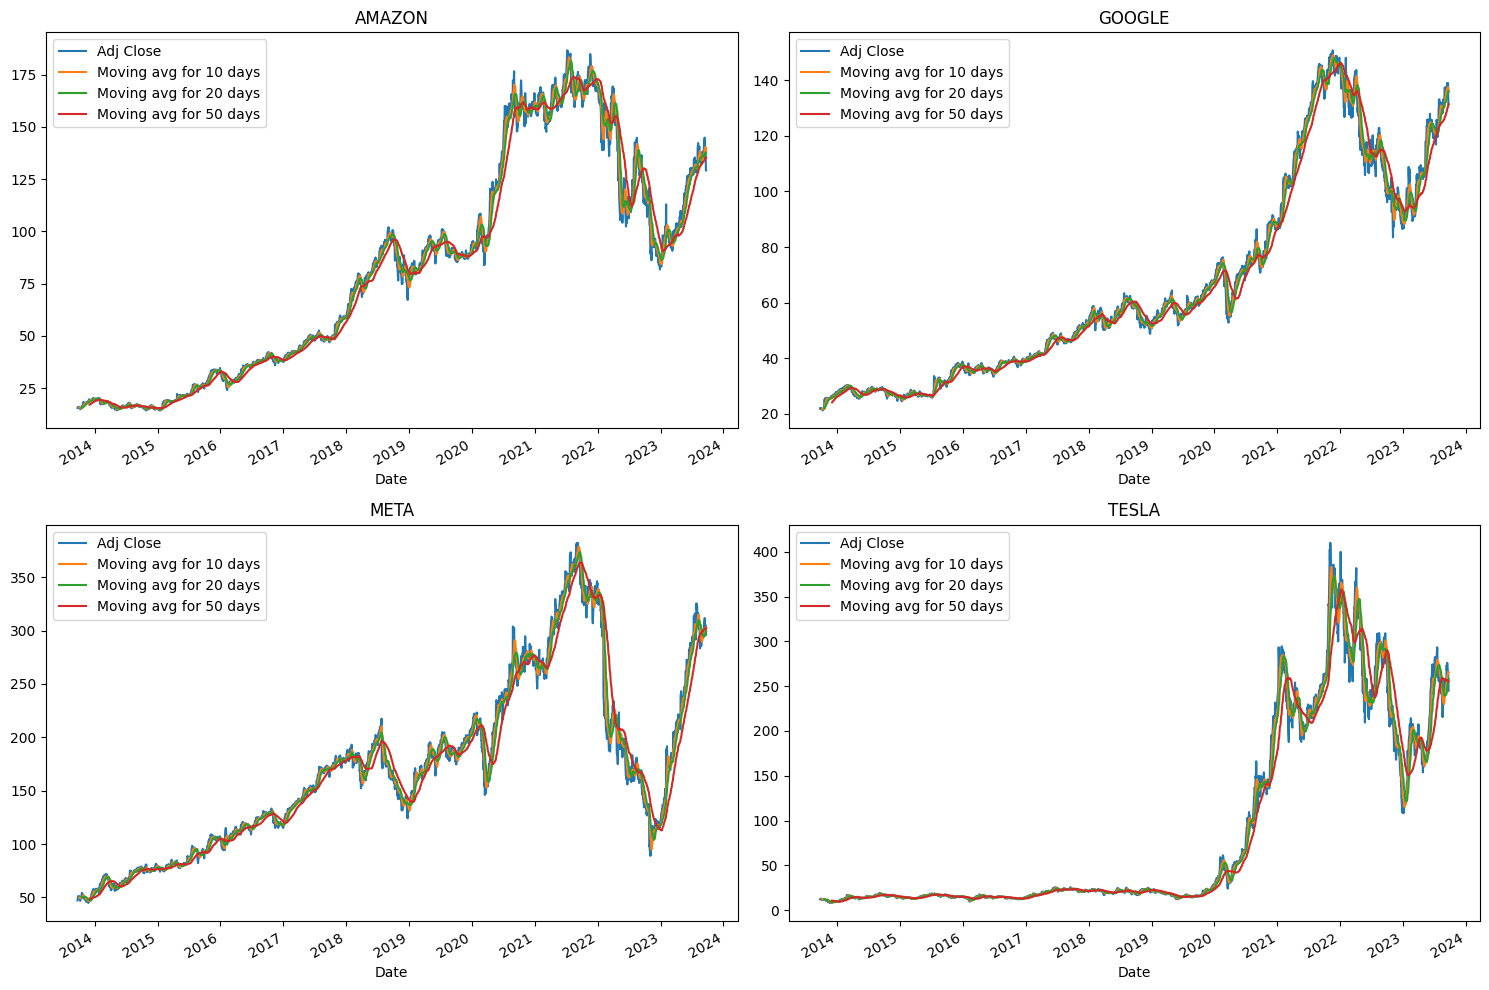

In [79]:
# Define a list of moving averages to calculate
moving_avg = [10, 20, 50]

# Iterate through each moving average period
for mv in moving_avg:
    # Iterate through each company in the company list
    for company in company_list:
        # Define the column name for the moving average
        column_name = f"Moving avg for {mv} days"

        # Calculate the moving average for the 'Adj Close' column and store it in a new column
        company[column_name] = company['Adj Close'].rolling(mv).mean()

# Create subplots for each company's stock data and moving averages
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

# Plot AMAZON stock data and moving averages
AMZN[["Adj Close", "Moving avg for 10 days", "Moving avg for 20 days", "Moving avg for 50 days"]].plot(ax=axes[0, 0])
axes[0, 0].set_title('AMAZON')

# Plot GOOGLE stock data and moving averages
GOOG[["Adj Close", "Moving avg for 10 days", "Moving avg for 20 days", "Moving avg for 50 days"]].plot(ax=axes[0, 1])
axes[0, 1].set_title('GOOGLE')

# Plot META stock data and moving averages
META[["Adj Close", "Moving avg for 10 days", "Moving avg for 20 days", "Moving avg for 50 days"]].plot(ax=axes[1, 0])
axes[1, 0].set_title('META')

# Plot TESLA stock data and moving averages
TSLA[["Adj Close", "Moving avg for 10 days", "Moving avg for 20 days", "Moving avg for 50 days"]].plot(ax=axes[1, 1])
axes[1, 1].set_title('TESLA')

# Adjust subplot layout for better visualization
fig.tight_layout()


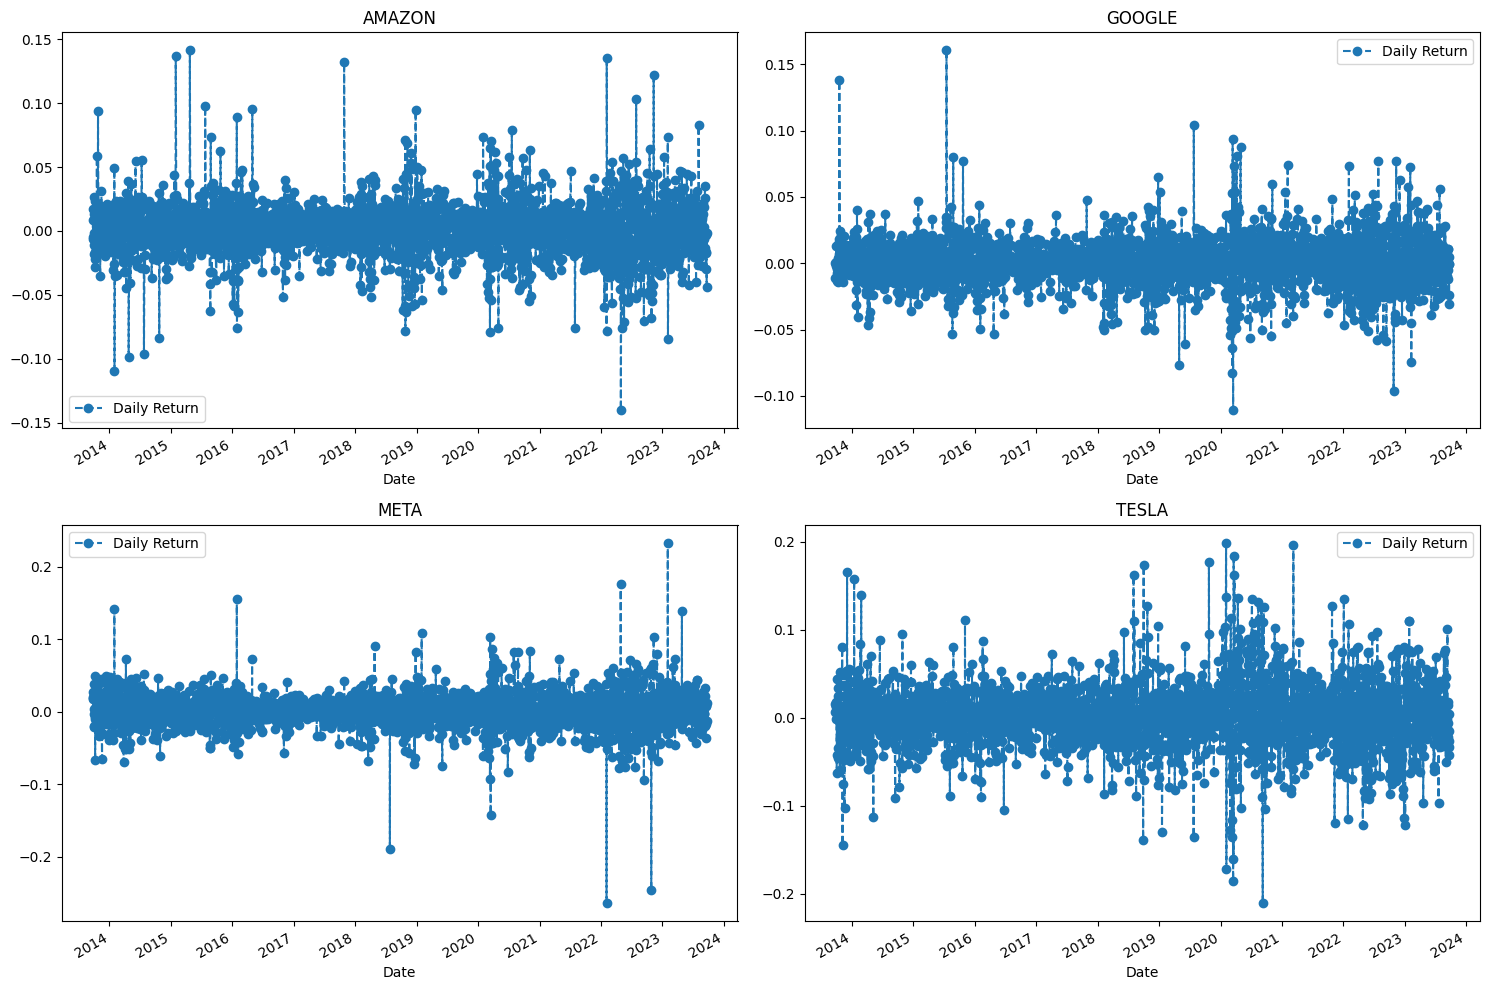

In [80]:
# Calculate daily returns for each company's stock data
for company in company_list:
    # Create a new column 'Daily Return' representing the percentage change in 'Adj Close'
    company["Daily Return"] = company["Adj Close"].pct_change()

# Create subplots for daily return visualization
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

# Plot daily returns for AMAZON with legend, linestyle, and marker customization
AMZN['Daily Return'].plot(ax=axes[0, 0], legend=True, linestyle='--', marker='o')
axes[0, 0].set_title('AMAZON')

# Plot daily returns for GOOGLE with legend, linestyle, and marker customization
GOOG['Daily Return'].plot(ax=axes[0, 1], legend=True, linestyle='--', marker='o')
axes[0, 1].set_title('GOOGLE')

# Plot daily returns for META with legend, linestyle, and marker customization
META['Daily Return'].plot(ax=axes[1, 0], legend=True, linestyle='--', marker='o')
axes[1, 0].set_title('META')

# Plot daily returns for TESLA with legend, linestyle, and marker customization
TSLA['Daily Return'].plot(ax=axes[1, 1], legend=True, linestyle='--', marker='o')
axes[1, 1].set_title('TESLA')

# Adjust subplot layout for better visualization
fig.tight_layout()


#Let's find out the correlations between all these datasets.

## Correlations Metrix

[*********************100%%**********************]  4 of 4 completed


Text(0.5, 1.0, 'Correlation of stock closing price')

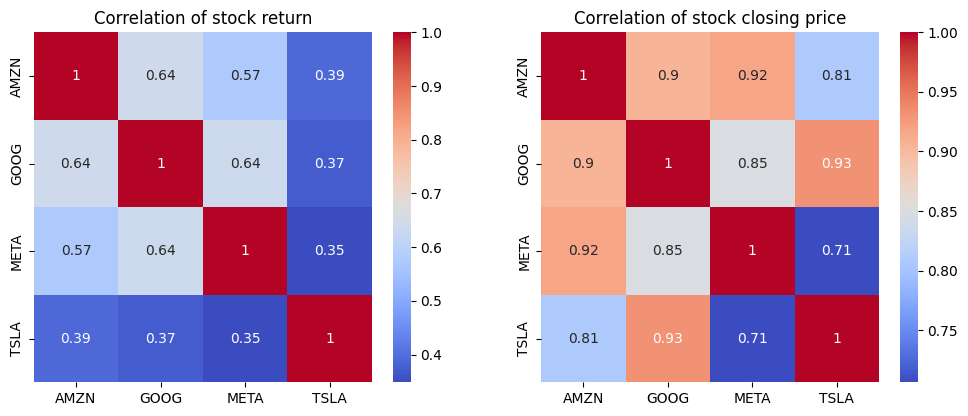

In [81]:
# Use pandas-datareader to fetch Adjusted Close prices for the specified company share list
closing_df = pdr.get_data_yahoo(company_share_list, start=start, end=end_time)['Adj Close']

# Calculate the daily percentage change (returns) for the fetched data
tech_return = closing_df.pct_change()

# Display the first few rows of the tech_return DataFrame
tech_return.head()

# Create a figure with subplots for correlation visualization
plt.figure(figsize=(12, 10))

# Plot the correlation matrix of stock returns in the first subplot
plt.subplot(2, 2, 1)
sns.heatmap(tech_return.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of stock return')

# Plot the correlation matrix of stock closing prices in the second subplot
plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of stock closing price')


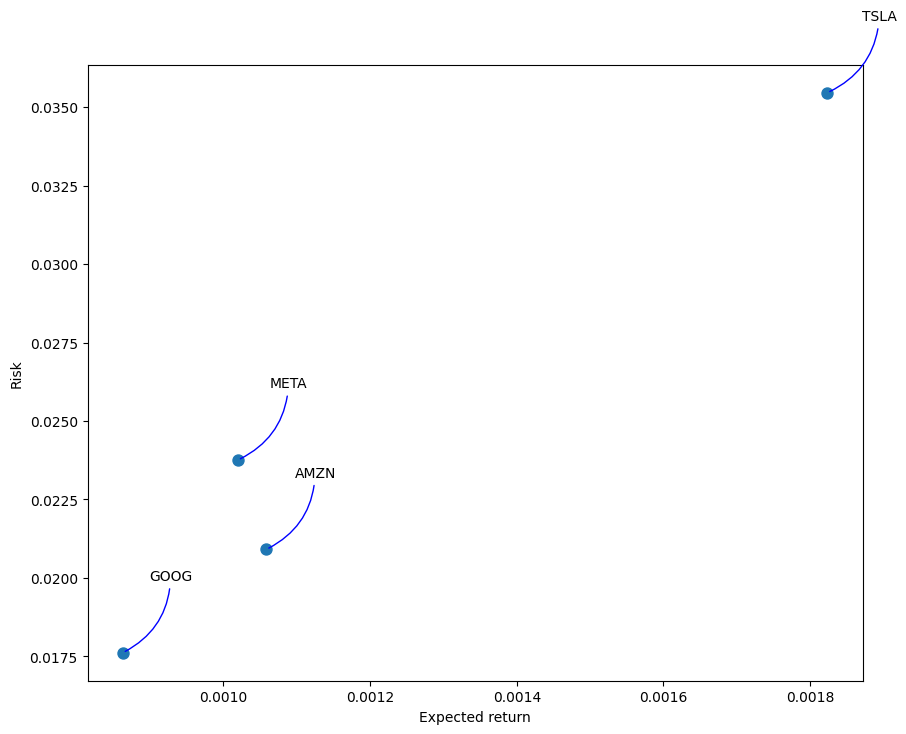

In [82]:
# Drop rows with missing values to ensure accurate calculations
rets = tech_return.dropna()

# Define the size of points on the scatter plot
area = np.pi * 20

# Create a scatter plot for expected return vs. risk
plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

# Annotate each point on the scatter plot with the corresponding label
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                  arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# Display the scatter plot
plt.show()



#Linear Regration model

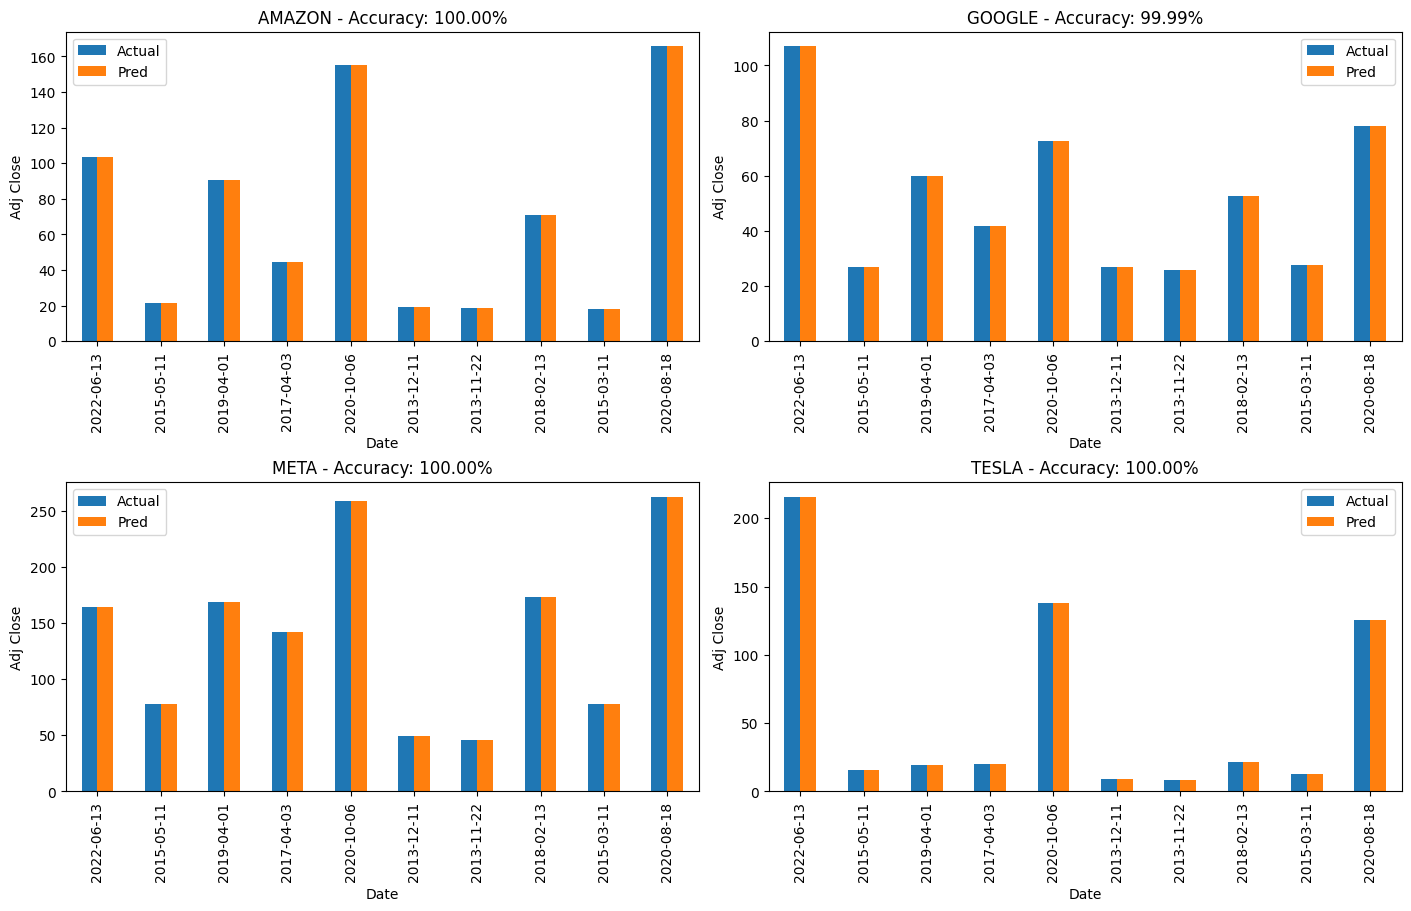

In [83]:
# Linear Model with Cross-validation

# Define a function to analyze stock data for multiple companies
def analyze_stock_data(df_comp_name):
    # Create subplots for visualization
    fig, axs = plt.subplots(2, 2, layout="constrained")

    # Initialize a global dictionary to store linear regression results
    global lm_results
    lm_results = {}

    # Iterate through the provided list of dataframes (df_comp_name)
    for i, df in enumerate(df_comp_name):
        # Extract features (X) and labels (Y)
        X = df[['Open', 'High', 'Low', 'Close']]
        Y = df['Adj Close']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

        # Create a Linear Regression model and fit it to the training data
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)

        # Make predictions on the testing data
        y_pred = lr_model.predict(X_test)

        # Perform Linear Model with Cross-validation
        kfold_model = KFold(n_splits=20, random_state=42, shuffle=True)
        res_kfod = cross_val_score(lr_model, X_train, y_train.astype('int'), cv=kfold_model)

        # Calculate and store evaluation metrics
        accuracy = res_kfod.mean() * 100
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        lm_results[company_name[i]] = {
            "results": {
                "accuracy": accuracy,
                "mse": mse,
                "rmse": rmse,
                "mae": mae,
                "r2": r2
            }
        }

        # Create a DataFrame for visualization and plot the data
        plot_df = pd.DataFrame({'Actual': y_test, 'Pred': y_pred})
        plot_df.index = plot_df.index.strftime('%Y-%m-%d')
        plot_df.head(10).plot(kind='bar', ax=axs[i // 2, i % 2], figsize=(14, 9))
        axs[i // 2, i % 2].set_title(f'{company_name[i]} - Accuracy: {accuracy:.2f}%')
        axs[i // 2, i % 2].set_xlabel('Date')
        axs[i // 2, i % 2].set_ylabel('Adj Close')

    # Display the plots
    plt.show()

# Call the function to analyze stock data for the provided datasets
analyze_stock_data(data_sets)



In [84]:
# Print lr result
lm_results
print("Company         |   Accuracy | MSE        | RMSE       | MAE        |      R2")
for company, results in lm_results.items():
  print(f"{company:15} | {results['results']['accuracy']:10.4f} | {results['results']['mse']:10.4e} | {results['results']['rmse']:10.4e} | {results['results']['mae']:10.4e} | {results['results']['r2']:10.4f}")


Company         |   Accuracy | MSE        | RMSE       | MAE        |      R2
AMAZON          |    99.9967 | 1.1109e-27 | 3.3330e-14 | 2.7313e-14 |     1.0000
GOOGLE          |    99.9930 | 3.6238e-28 | 1.9036e-14 | 1.4234e-14 |     1.0000
META            |    99.9986 | 8.8499e-27 | 9.4074e-14 | 7.3752e-14 |     1.0000
TESLA           |    99.9992 | 9.9687e-26 | 3.1573e-13 | 2.7873e-13 |     1.0000


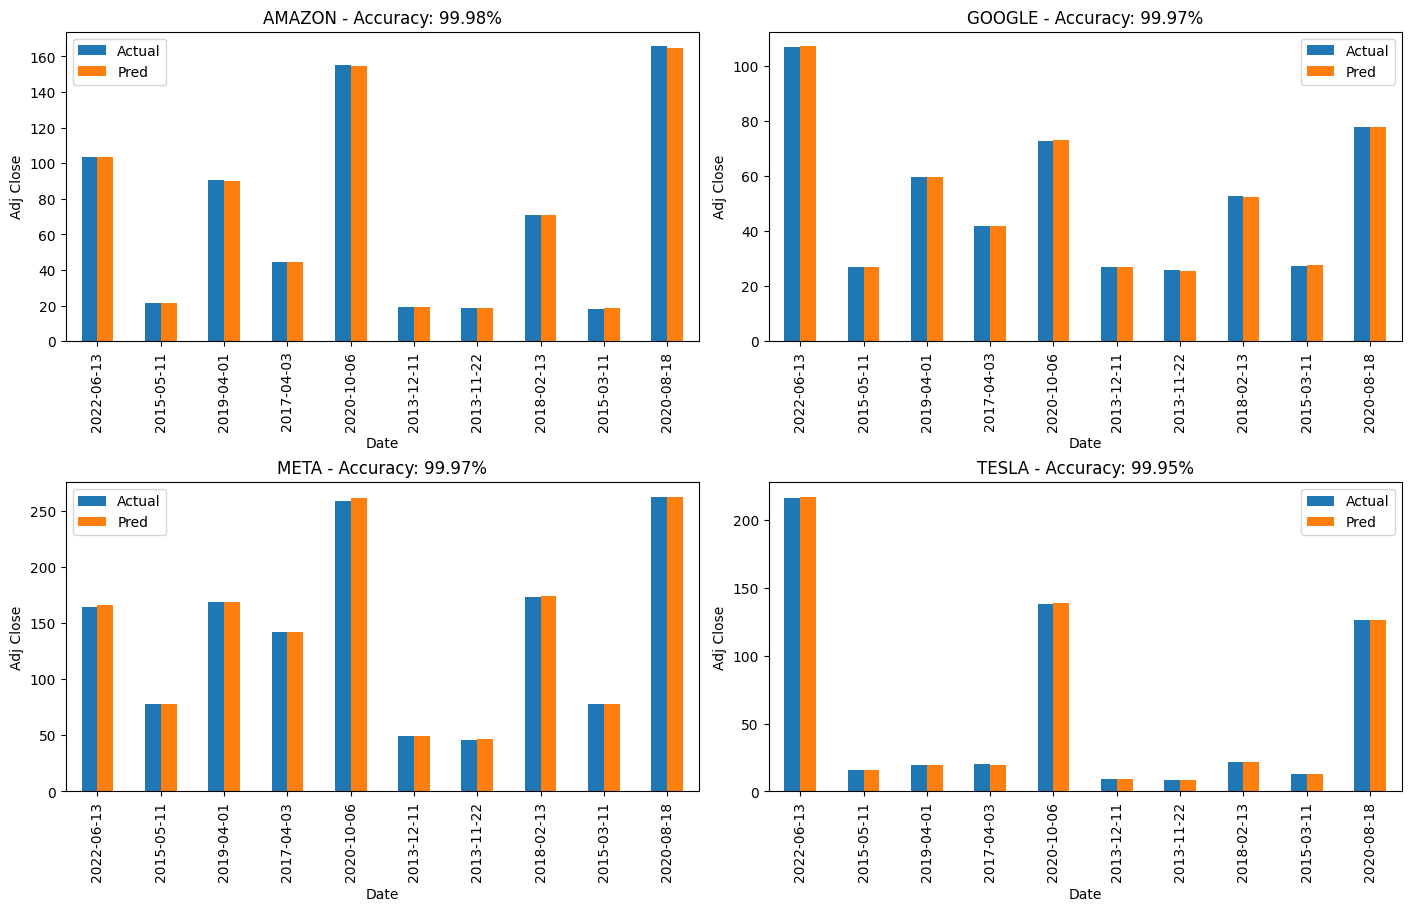

In [85]:
# Define a function to analyze stock data using K-Nearest Neighbors (KNN) regression
def analyze_stocks_knn(dataframes):
    # Create subplots for visualization
    fig, axs = plt.subplots(2, 2, layout="constrained")

    # Initialize a global dictionary to store KNN regression results
    global lm_results_knn
    lm_results_knn = {}

    # Iterate through the provided list of dataframes (dataframes)
    for i, df in enumerate(dataframes):
        # Extract features (X) and labels (Y)
        X = df[['Open', 'High', 'Low', 'Close']]
        Y = df['Adj Close']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

        # Create a K-Nearest Neighbors (KNN) regression model and fit it to the training data
        knn_regression = KNeighborsRegressor(n_neighbors=5)
        knn_model = knn_regression.fit(X_train, y_train)
        y_knn_pred = knn_model.predict(X_test)

        # Perform K-Fold Cross-validation with KNN model
        knn_Kfold = KFold(n_splits=20, random_state=42, shuffle=True)
        res_kfold = cross_val_score(knn_model, X_test, y_test.astype('int'), cv=knn_Kfold)

        # Calculate and store evaluation metrics
        accuracy = res_kfold.mean() * 100
        mse = mean_squared_error(y_test, y_knn_pred)
        rmse = mean_squared_error(y_test, y_knn_pred, squared=False)
        mae = mean_absolute_error(y_test, y_knn_pred)
        r2 = r2_score(y_test, y_knn_pred)

        lm_results_knn[company_name[i]] = {
            "results": {
                "accuracy": accuracy,
                "mse": mse,
                "rmse": rmse,
                "mae": mae,
                "r2": r2
            }
        }

        # Create a DataFrame for visualization and plot the data
        plot_df = pd.DataFrame({'Actual': y_test, 'Pred': y_knn_pred})
        plot_df.index = plot_df.index.strftime('%Y-%m-%d')

        # Plot the first 10 data points
        plot_df.head(10).plot(kind='bar', ax=axs[i // 2, i % 2], figsize=(14, 9))
        axs[i // 2, i % 2].set_title(f'{company_name[i]} - Accuracy: {accuracy:.2f}%')
        axs[i // 2, i % 2].set_xlabel('Date')
        axs[i // 2, i % 2].set_ylabel('Adj Close')

    # Display the plots
    plt.show()

# Call the function to analyze stock data using KNN regression for the provided datasets
analyze_stocks_knn(data_sets)


In [86]:
# Print the result from lm_results_knn
lm_results_knn
print("Company         |   Accuracy | MSE        | RMSE       | MAE        |      R2")
for company, results in lm_results_knn.items():
  print(f"{company:15} | {results['results']['accuracy']:10.4f} | {results['results']['mse']:10.4e} | {results['results']['rmse']:10.4e} | {results['results']['mae']:10.4e} | {results['results']['r2']:10.4f}")


Company         |   Accuracy | MSE        | RMSE       | MAE        |      R2
AMAZON          |    99.9783 | 1.9522e-01 | 4.4183e-01 | 2.7446e-01 |     0.9999
GOOGLE          |    99.9732 | 1.1779e-01 | 3.4321e-01 | 2.1386e-01 |     0.9999
META            |    99.9725 | 1.1065e+00 | 1.0519e+00 | 6.9616e-01 |     0.9998
TESLA           |    99.9453 | 2.5732e+00 | 1.6041e+00 | 6.1552e-01 |     0.9998


### Linear Regression model with daily fluctuation

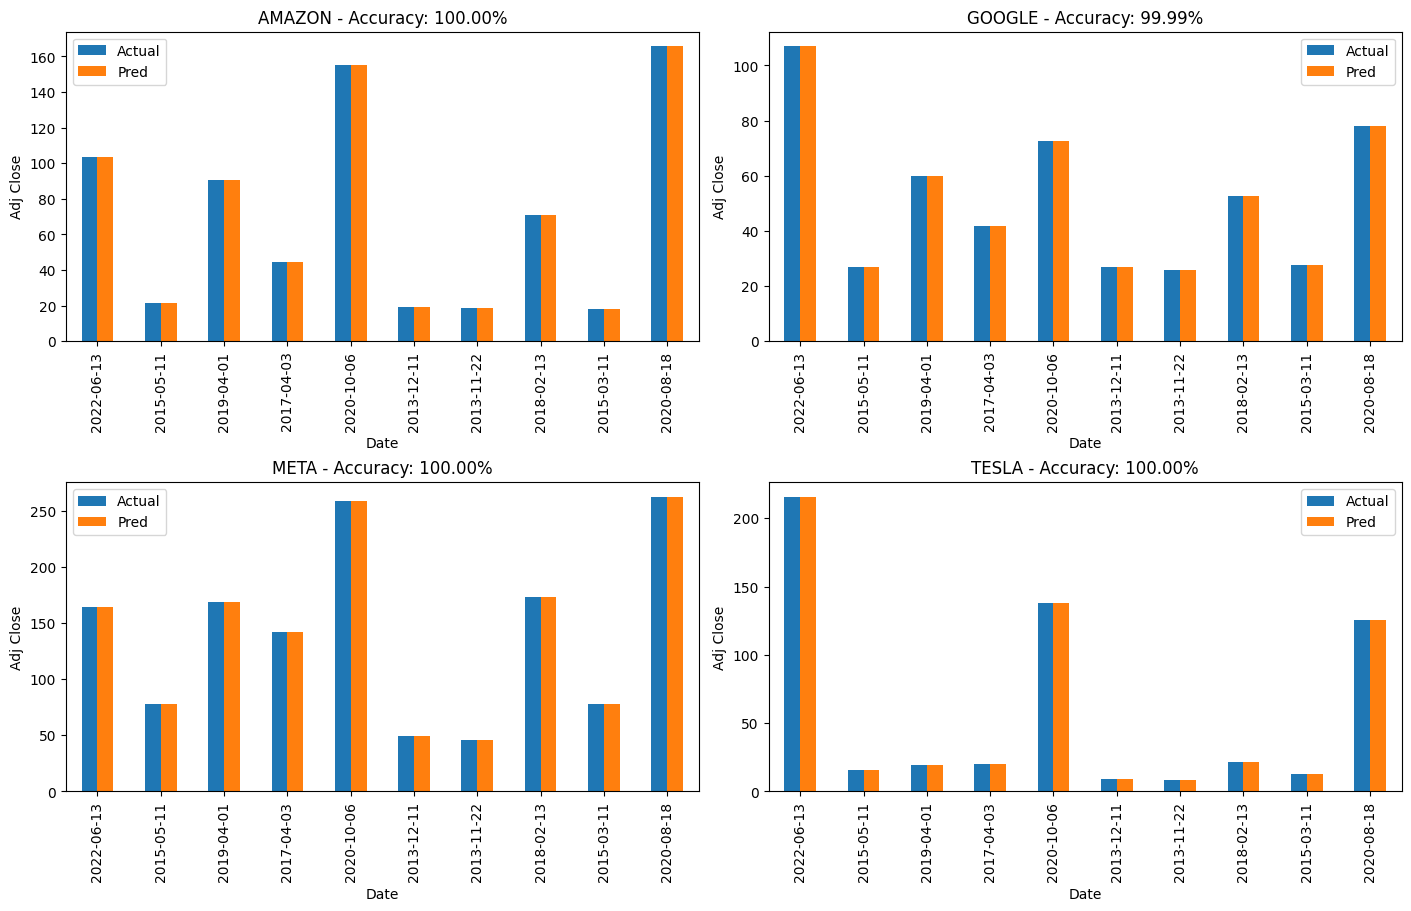

In [87]:
# Define a function to analyze day-to-day fluctuation impact on stock data
def analyze_day_fluctuation(df_comp_name):
    # Create subplots for visualization
    fig, axs = plt.subplots(2, 2, layout="constrained")

    # Initialize a global dictionary to store Linear Regression results
    global lm_results_day_fluctuation
    lm_results_day_fluctuation = {}

    # Iterate through the provided list of dataframes (df_comp_name)
    for i, df in enumerate(df_comp_name):
        # Calculate day-to-day fluctuation and add it as a new column
        day_fluctuation = df['Open'] - df['Close']
        df['day_fluctuation'] = day_fluctuation

        # Define features (X) and labels (Y)
        X = df[["Open", "High", "Low", "day_fluctuation"]]
        Y = df["Adj Close"]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

        # Create a Linear Regression model and fit it to the training data
        model_day_fluctuation = LinearRegression()
        model_day_fluctuation.fit(X_train, y_train)
        y_pred = model_day_fluctuation.predict(X_test)

        # Linear Model with Cross-validation
        kfold_model = KFold(n_splits=20, random_state=42, shuffle=True)
        res_kfod = cross_val_score(model_day_fluctuation, X_train, y_train.astype('int'), cv=kfold_model)

        # Calculate and store evaluation metrics
        accuracy = res_kfod.mean() * 100
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        lm_results_day_fluctuation[company_name[i]] = {
            "results": {
                "accuracy": accuracy,
                "mse": mse,
                "rmse": rmse,
                "mae": mae,
                "r2": r2
            }
        }

        # Create a DataFrame for visualization and plot the data
        plot_df = pd.DataFrame({'Actual': y_test, 'Pred': y_pred})
        plot_df.index = plot_df.index.strftime('%Y-%m-%d')

        # Plot the first 10 data points
        plot_df.head(10).plot(kind='bar', ax=axs[i // 2, i % 2], figsize=(14, 9))
        axs[i // 2, i % 2].set_title(f'{company_name[i]} - Accuracy: {accuracy:.2f}%')
        axs[i // 2, i % 2].set_xlabel('Date')
        axs[i // 2, i % 2].set_ylabel('Adj Close')

    # Display the plots
    plt.show()

# Call the function to analyze day-to-day fluctuation impact on stock data
analyze_day_fluctuation(data_sets)


In [88]:
# Print results
lm_results_day_fluctuation

lm_results_day_fluctuation
print("Company         |   Accuracy | MSE        | RMSE       | MAE        |      R2")
for company, results in lm_results_day_fluctuation.items():
  print(f"{company:15} | {results['results']['accuracy']:10.4f} | {results['results']['mse']:10.4e} | {results['results']['rmse']:10.4e} | {results['results']['mae']:10.4e} | {results['results']['r2']:10.4f}")


Company         |   Accuracy | MSE        | RMSE       | MAE        |      R2
AMAZON          |    99.9967 | 1.1692e-27 | 3.4194e-14 | 2.8875e-14 |     1.0000
GOOGLE          |    99.9930 | 1.4965e-25 | 3.8684e-13 | 3.2113e-13 |     1.0000
META            |    99.9986 | 6.4144e-28 | 2.5327e-14 | 1.6626e-14 |     1.0000
TESLA           |    99.9992 | 1.9635e-26 | 1.4013e-13 | 1.2112e-13 |     1.0000


#ANN Models
Artificial neural networks (ANN): ANNs are a type of machine learning algorithm that are inspired by the human brain. They are able to learn complex patterns and relationships in data, which makes them well-suited for stock trend prediction.

## LSTM model

###Amazon

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
4/4 [==============================] - 1s 18ms/step
Mean Squared Error (MSE): 235.77356954262032
Root Mean Squared Error (RMSE): 15.354920043511145
Mean Absolute Error (MAE): 14.924946411132812
R-squared (Coefficient of Determination): -0.2869959812198122


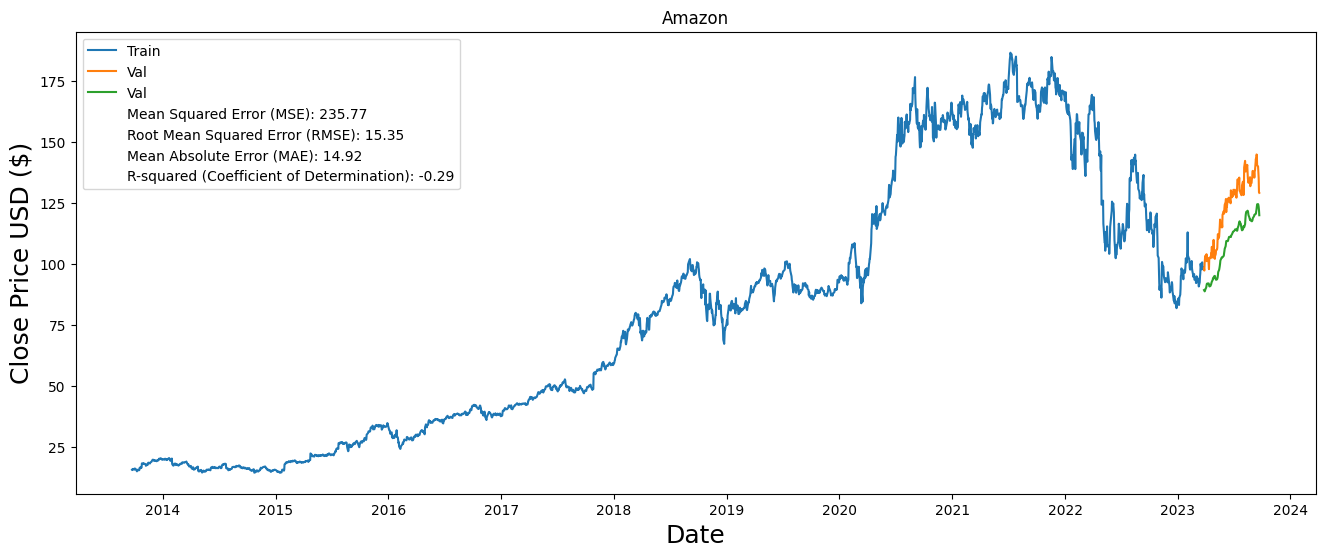

In [89]:
# Import necessary libraries and set up reproducibility
setup_reproducibility()

# Define the data source (in this case, Amazon stock data)
data = df_amaz

# Function to preprocess the data
def preprocess_data(data):
    # Extract the 'Close' price and normalize it
    dataset = data.filter(['Close']).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the training data length (95% of the dataset)
    training_data_len = int(np.ceil(len(dataset) * 0.95))

    return scaled_data, scaler, training_data_len, dataset

# Function to generate training data sequences
def generate_train_data(scaled_data, sequence_length):
    train_data = scaled_data[0:int(training_data_len), :]

    x_train = []
    y_train = []

    for i in range(sequence_length, len(train_data)):
        x_train.append(train_data[i-sequence_length:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the LSTM model
def train_model(model, x_train, y_train, batch_size, epochs):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Function to generate test predictions and evaluate the model
def generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length):
    test_data = scaled_data[training_data_len - sequence_length:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(sequence_length, len(test_data)):
        x_test.append(test_data[i-sequence_length:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Calculate evaluation metrics
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store evaluation metrics in a dictionary
    evaluation_metrics = {
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (Coefficient of Determination)": r2
    }

    return predictions, rmse, evaluation_metrics

# Preprocess the data
scaled_data, scaler, training_data_len, dataset = preprocess_data(data)

# Set the sequence length
sequence_length = 60

# Generate training data sequences
x_train, y_train = generate_train_data(scaled_data, sequence_length)

# Reshape the data for LSTM input
input_shape = (x_train.shape[1], 1)
x_train = np.reshape(x_train, (x_train.shape[0], input_shape[0], 1))

# Build the LSTM model
model = build_model(input_shape)

# Train the model (you can specify batch size and epochs)
train_model(model, x_train, y_train, batch_size=1, epochs=1)

# Generate test predictions and evaluation metrics
predictions, rmse, evaluation_metrics = generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length)

# Visualize the data and predictions
data = data.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data and predictions
plt.figure(figsize=(16, 6))
plt.title('Amazon')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Train')  # Plot training data's 'Close'
plt.plot(valid[['Close', 'Predictions']], label='Val')  # Plot validation data's 'Close' and 'Predictions'

# Create the first legend for 'Train' and 'Val'
plt.legend(loc='lower right')

# Create the second legend for evaluation metrics
for key, value in evaluation_metrics.items():
    print(f"{key}: {value}")
    plt.plot([], [], label=f'{key}: {value:.2f}', color='white')  # Empty plot with label

# Position the second legend in the 'upper left' corner
plt.legend(loc='upper left')

plt.show()


###Google

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
4/4 [==============================] - 1s 18ms/step
Mean Squared Error (MSE): 13.03767962025851
Root Mean Squared Error (RMSE): 3.6107727178899687
Mean Absolute Error (MAE): 2.81386181640625
R-squared (Coefficient of Determination): 0.8863883764086657


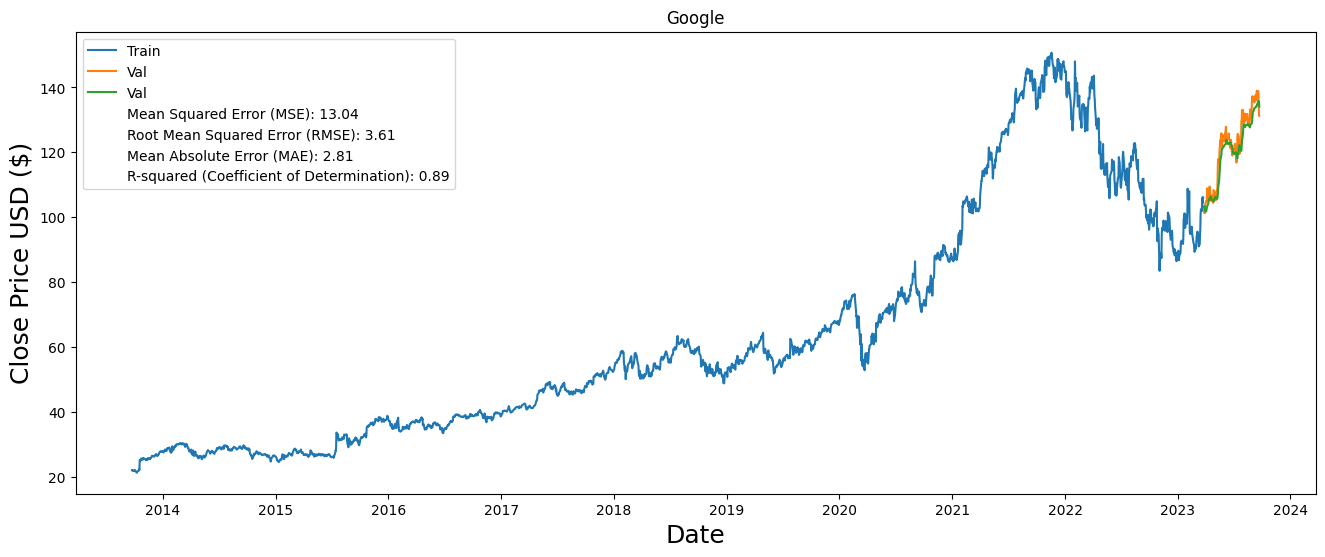

In [90]:

# reproducibly using Keras
setup_reproducibility()


# Define the data source (in this case, Google stock data)
data = df_googl

# Function to preprocess the data
def preprocess_data(data):
    # Extract the 'Close' price and normalize it
    dataset = data.filter(['Close']).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the training data length (95% of the dataset)
    training_data_len = int(np.ceil(len(dataset) * 0.95))

    return scaled_data, scaler, training_data_len, dataset

# Function to generate training data sequences
def generate_train_data(scaled_data, sequence_length):
    train_data = scaled_data[0:int(training_data_len), :]

    x_train = []
    y_train = []

    for i in range(sequence_length, len(train_data)):
        x_train.append(train_data[i-sequence_length:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the LSTM model
def train_model(model, x_train, y_train, batch_size, epochs):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Function to generate test predictions and evaluate the model
def generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length):
    test_data = scaled_data[training_data_len - sequence_length:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(sequence_length, len(test_data)):
        x_test.append(test_data[i-sequence_length:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Calculate evaluation metrics
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store evaluation metrics in a dictionary
    evaluation_metrics = {
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (Coefficient of Determination)": r2
    }

    return predictions, rmse, evaluation_metrics


# Preprocess data

scaled_data, scaler, training_data_len, dataset = preprocess_data(data)

# Create sequences
sequence_length = 60
#x_train, y_train = create_sequences(scaled_data, sequence_length)
x_train, y_train = generate_train_data(scaled_data, sequence_length)

# Reshape the data
input_shape = (x_train.shape[1], 1)
x_train = np.reshape(x_train, (x_train.shape[0], input_shape[0], 1))

# Build the model
model = build_model(input_shape)

# Train the model
train_model(model, x_train, y_train, batch_size=1, epochs=1)

# Predict and evaluate

predictions, rmse, evaluation_metrics = generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length)

data = data.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions



# Visualize the data
plt.figure(figsize=(16, 6))
plt.title('Google')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Train')  # Plot training data's 'Close'
plt.plot(valid[['Close', 'Predictions']], label='Val')  # Plot validation data's 'Close' and 'Predictions'

# Create the first legend for 'Train' and 'Val'
plt.legend(loc='lower right')

# Create the second legend for evaluation metrics
for key, value in evaluation_metrics.items():
    print(f"{key}: {value}")
    plt.plot([], [], label=f'{key}: {value:.2f}', color='white')  # Empty plot with label

# Position the second legend in the 'upper left' corner
plt.legend(loc='upper left')

plt.show()


###Meta

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
4/4 [==============================] - 1s 16ms/step
Mean Squared Error (MSE): 91.61946961868927
Root Mean Squared Error (RMSE): 9.571805974772435
Mean Absolute Error (MAE): 7.5211884765625
R-squared (Coefficient of Determination): 0.927417368868217


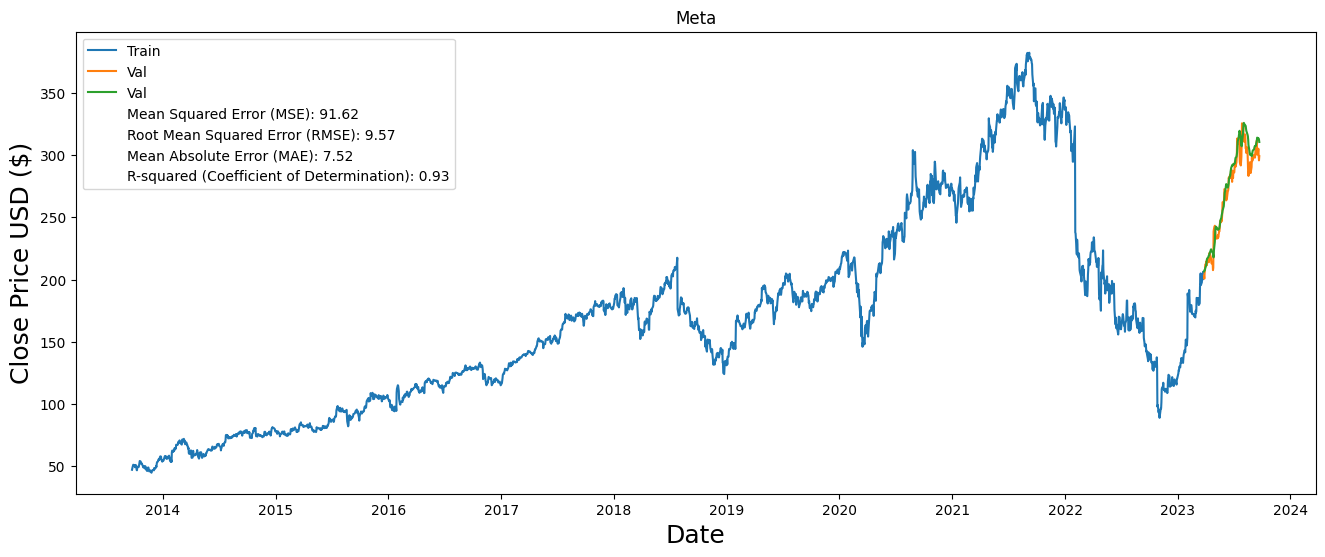

In [91]:
# reproducibly using Keras
setup_reproducibility()

# Set the random seed for TensorFlow
#tf.random.set_seed(221)

# Define the data source (in this case, Meta stock data)
data = df_meta

# Function to preprocess the data
def preprocess_data(data):
    # Extract the 'Close' price and normalize it
    dataset = data.filter(['Close']).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the training data length (95% of the dataset)
    training_data_len = int(np.ceil(len(dataset) * 0.95))

    return scaled_data, scaler, training_data_len, dataset

# Function to generate training data sequences
def generate_train_data(scaled_data, sequence_length):
    train_data = scaled_data[0:int(training_data_len), :]

    x_train = []
    y_train = []

    for i in range(sequence_length, len(train_data)):
        x_train.append(train_data[i-sequence_length:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the LSTM model
def train_model(model, x_train, y_train, batch_size, epochs):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Function to generate test predictions and evaluate the model
def generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length):
    test_data = scaled_data[training_data_len - sequence_length:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(sequence_length, len(test_data)):
        x_test.append(test_data[i-sequence_length:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Calculate evaluation metrics
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store evaluation metrics in a dictionary
    evaluation_metrics = {
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (Coefficient of Determination)": r2
    }

    return predictions, rmse, evaluation_metrics


# Preprocess data

scaled_data, scaler, training_data_len, dataset = preprocess_data(data)

# Create sequences
sequence_length = 60
#x_train, y_train = create_sequences(scaled_data, sequence_length)
x_train, y_train = generate_train_data(scaled_data, sequence_length)

# Reshape the data
input_shape = (x_train.shape[1], 1)
x_train = np.reshape(x_train, (x_train.shape[0], input_shape[0], 1))

# Build the model
model = build_model(input_shape)

# Train the model
train_model(model, x_train, y_train, batch_size=1, epochs=1)

# Predict and evaluate

predictions, rmse, evaluation_metrics = generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length)

data = data.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 6))
plt.title('Meta')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Train')  # Plot training data's 'Close'
plt.plot(valid[['Close', 'Predictions']], label='Val')  # Plot validation data's 'Close' and 'Predictions'

# Create the first legend for 'Train' and 'Val'
plt.legend(loc='lower right')

# Create the second legend for evaluation metrics
for key, value in evaluation_metrics.items():
    print(f'{key}: {value}')
    plt.plot([], [], label=f'{key}: {value:.2f}', color='white')  # Empty plot with label

# Position the second legend in the 'upper left' corner
plt.legend(loc='upper left')

plt.show()


###Tesla

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
4/4 [==============================] - 1s 16ms/step
Mean Squared Error (MSE): 235.56089053297228
Root Mean Squared Error (RMSE): 15.347993045768957
Mean Absolute Error (MAE): 12.510428588867187
R-squared (Coefficient of Determination): 0.8562387839232788


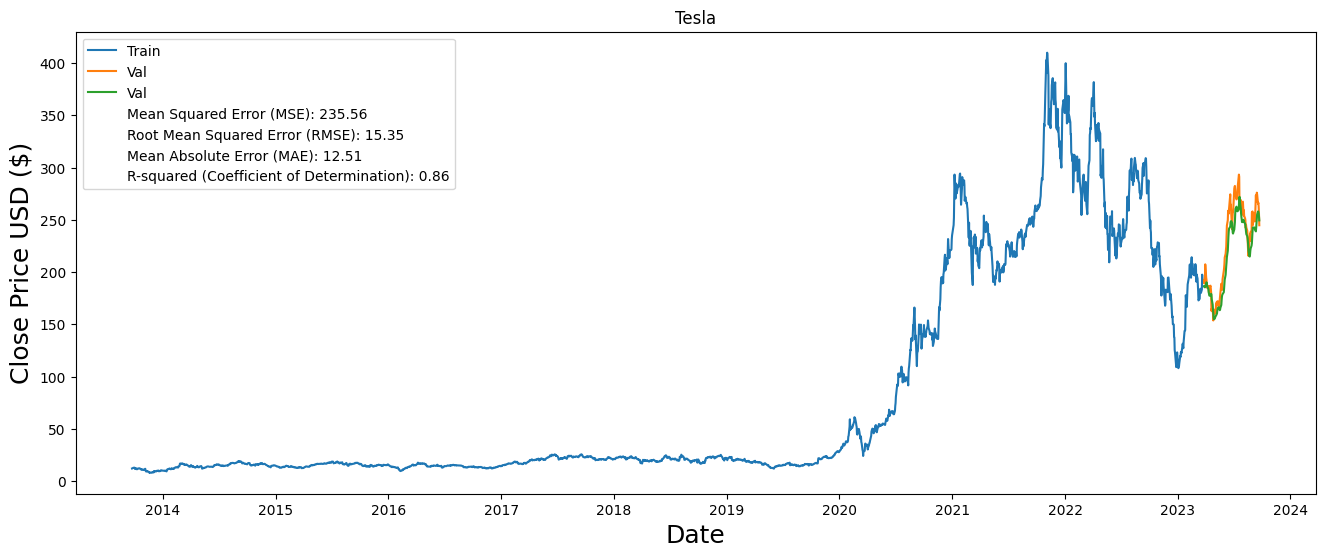

In [92]:
# reproducibly using Keras
setup_reproducibility()

# Define the data source (in this case, Tesla stock data)
data = df_tsla

# Function to preprocess the data
def preprocess_data(data):
    # Extract the 'Close' price and normalize it
    dataset = data.filter(['Close']).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the training data length (95% of the dataset)
    training_data_len = int(np.ceil(len(dataset) * 0.95))

    return scaled_data, scaler, training_data_len, dataset

# Function to generate training data sequences
def generate_train_data(scaled_data, sequence_length):
    train_data = scaled_data[0:int(training_data_len), :]

    x_train = []
    y_train = []

    for i in range(sequence_length, len(train_data)):
        x_train.append(train_data[i-sequence_length:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train

# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the LSTM model
def train_model(model, x_train, y_train, batch_size, epochs):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Function to generate test predictions and evaluate the model
def generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length):
    test_data = scaled_data[training_data_len - sequence_length:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(sequence_length, len(test_data)):
        x_test.append(test_data[i-sequence_length:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Calculate evaluation metrics
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store evaluation metrics in a dictionary
    evaluation_metrics = {
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (Coefficient of Determination)": r2
    }

    return predictions, rmse, evaluation_metrics


# Preprocess data

scaled_data, scaler, training_data_len, dataset = preprocess_data(data)

# Create sequences
sequence_length = 60
#x_train, y_train = create_sequences(scaled_data, sequence_length)
x_train, y_train = generate_train_data(scaled_data, sequence_length)

# Reshape the data
input_shape = (x_train.shape[1], 1)
x_train = np.reshape(x_train, (x_train.shape[0], input_shape[0], 1))

# Build the model
model = build_model(input_shape)

# Train the model
train_model(model, x_train, y_train, batch_size=1, epochs=1)

# Predict and evaluate

predictions, rmse, evaluation_metrics = generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length)

data = data.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


# Visualize the data
plt.figure(figsize=(16, 6))
plt.title('Tesla')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Train')  # Plot training data's 'Close'
plt.plot(valid[['Close', 'Predictions']], label='Val')  # Plot validation data's 'Close' and 'Predictions'

# Create the first legend for 'Train' and 'Val'
plt.legend(loc='lower right')

# Create the second legend for evaluation metrics
for key, value in evaluation_metrics.items():
    print(f"{key}: {value}")
    plt.plot([], [], label=f'{key}: {value:.2f}', color='white')  # Empty plot with label

# Position the second legend in the 'upper left' corner
plt.legend(loc='upper left')

plt.show()


##ANN model with dense

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
4/4 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 700.2408558228612
Root Mean Squared Error (RMSE): 26.462064466380195
Mean Absolute Error (MAE): 22.62394189453125
R-squared (Coefficient of Determination): 0.5726477483085941


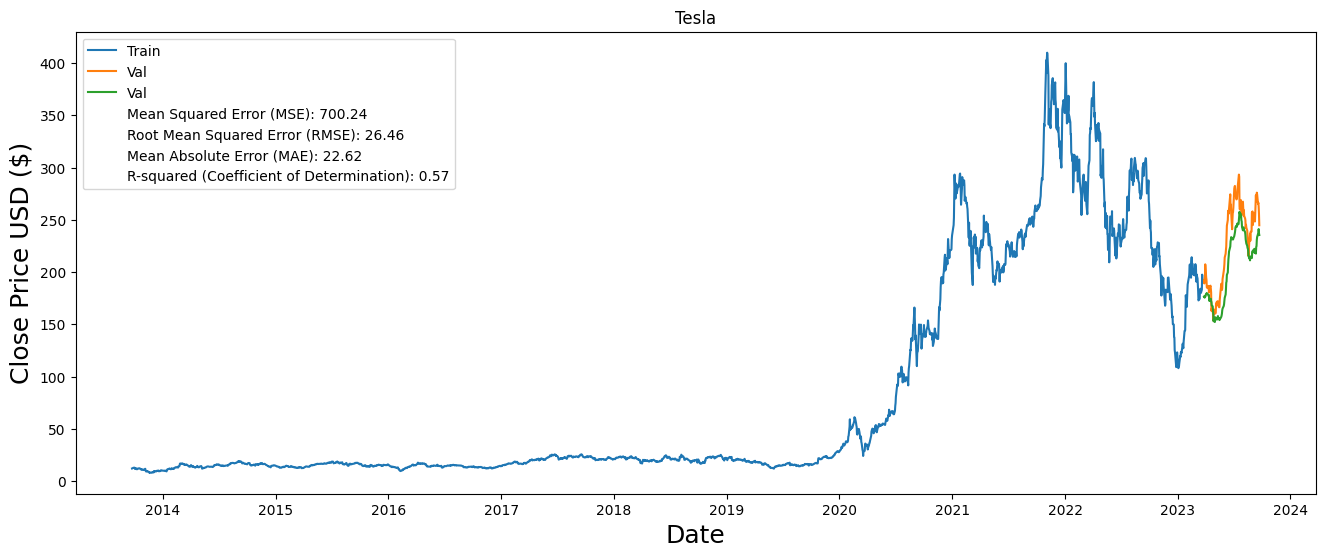

In [93]:
# reproducibly using Keras
setup_reproducibility()

# Select Tesla (TSLA) stock data
data = df_tsla

# Function to preprocess the data
def preprocess_data(data):
    # Extract the 'Close' price and normalize it
    dataset = data.filter(['Close']).values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the training data length (95% of the dataset)
    training_data_len = int(np.ceil(len(dataset) * 0.95))

    return scaled_data, scaler, training_data_len, dataset

# Function to generate training data sequences
def generate_train_data(scaled_data, sequence_length):
    train_data = scaled_data[0:int(training_data_len), :]

    x_train = []
    y_train = []

    for i in range(sequence_length, len(train_data)):
        x_train.append(train_data[i-sequence_length:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    return x_train, y_train

# Function to build the neural network model
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

# Function to train the neural network model
def train_model(model, x_train, y_train, batch_size, epochs):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

# Function to generate test predictions and evaluate the model
def generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length):
    test_data = scaled_data[training_data_len - sequence_length:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(sequence_length, len(test_data)):
        x_test.append(test_data[i-sequence_length:i, 0])

    x_test = np.array(x_test)

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Calculate evaluation metrics
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store evaluation metrics in a dictionary
    evaluation_metrics = {
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "R-squared (Coefficient of Determination)": r2
    }

    return predictions, rmse, evaluation_metrics



# Preprocess data
scaled_data, scaler, training_data_len, dataset = preprocess_data(data)

# Create sequences
sequence_length = 60
#x_train, y_train = create_sequences(scaled_data, sequence_length)
x_train, y_train = generate_train_data(scaled_data, sequence_length)

# Reshape the data
input_shape = (x_train.shape[1])
#x_train = np.reshape(x_train, (x_train.shape[0], input_shape[0], 1))

# Build the model
model = build_model(input_shape)

# Train the model
train_model(model, x_train, y_train, batch_size=1, epochs=1)

# Predict and evaluate

predictions, rmse, evaluation_metrics = generate_test_predictions(model, scaled_data, dataset, scaler, sequence_length)

data = data.filter(['Close'])
train = data[:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 6))
plt.title('Tesla')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Train')  # Plot training data's 'Close'
plt.plot(valid[['Close', 'Predictions']], label='Val')  # Plot validation data's 'Close' and 'Predictions'

# Create the first legend for 'Train' and 'Val'
plt.legend(loc='lower right')

# Create the second legend for evaluation metrics
for key, value in evaluation_metrics.items():
    print(f"{key}: {value}")
    plt.plot([], [], label=f'{key}: {value:.2f}', color='white')  # Empty plot with label

# Position the second legend in the 'upper left' corner
plt.legend(loc='upper left')

plt.show()


In [94]:
def dense_model(datasets):
  setup_reproducibility()


  global sq_results
  sq_results = {}
  # Create the features

  for i, df in enumerate(datasets):
    features = df[["Open", "High", "Low", "Close"]]

    # Create the labels
    labels = df["Adj Close"]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Create the model
    model = Sequential()
    model.add(Dense(100, activation="relu", input_shape=(4,)))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation="linear"))

    # Train the model
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train, epochs=100)

    # Evaluate the model
    model.evaluate(X_test, y_test)

    # Make predictions
    predictions = model.predict(X_test)


    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)



    # Evaluate the model
    # Print the evaluation metrics
    sq_results[company_name[i]] = {
        "results":{
                  "Mean Squared Error (MSE)": mse,
                  "Root Mean Squared Error (RMSE)": rmse,
                  "Mean Absolute Error (MAE)":mae,
                  "R-squared (Coefficient of Determination)": r2}}


dense_model(data_sets)





Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Epoch 1/100
63/63 [==============================] - 1s 1ms/step - loss: 272.7361
Epoch 2/100
63/63 [==============================] - 0s 1ms/step - loss: 1.0178
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.8060
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.8022
Epoch 5/100
63/63 [==============================] - 0s 1ms/step - loss: 0.8064
Epoch 6/100
63/63 [==============================] - 0s 1ms/step - loss: 0.7758
Epoch 7/100
63/63 [==============================] - 0s 1ms/step - loss: 0.8135
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.8440
Epoch 9/100
63/63 [==============================] - 0s 1ms/step - loss: 0.7486
Epoch 10/100
63/63 [==============================] - 0s 1ms/step - loss: 0.7772
Epoch 11/100
63/63 [==============================] - 0s 1ms/step - loss: 0.7813
Epoch 12/100
63/63 [=========================

In [95]:
sq_results
# Print the table
print("Company          | MSE        | RMSE       | MAE        |      R2")
for company, results in sq_results.items():
  print(f"{company:15} | {results['results']['Mean Squared Error (MSE)']:10.2e} | {results['results']['Root Mean Squared Error (RMSE)']:10.4e} | {results['results']['Mean Absolute Error (MAE)']:10.4e} | {results['results']['R-squared (Coefficient of Determination)']:10.4f}")

Company          | MSE        | RMSE       | MAE        |      R2
AMAZON          |   7.79e-03 | 8.8263e-02 | 5.2353e-02 |     1.0000
GOOGLE          |   6.98e-03 | 8.3552e-02 | 5.4472e-02 |     1.0000
META            |   5.14e-01 | 7.1680e-01 | 6.1618e-01 |     0.9999
TESLA           |   3.51e-01 | 5.9257e-01 | 3.4995e-01 |     1.0000


# Support vector machines (SVM)
SVMs are another type of machine learning algorithm that are known for their accuracy. They work by finding the hyperplane that best separates the data into two classes. This hyperplane can then be used to predict future values.

### Support Vector Regression

In [96]:
def train_and_evaluate_svr(datasets):
    """
    Train and evaluate a Support Vector Regression (SVR) model.

    Parameters:
    - features: DataFrame or array-like, containing the input features.
    - labels: Series or array-like, containing the target labels.
    - test_size: Proportion of the dataset to include in the test split (default=0.2).
    - random_state: Seed for random number generation (default=42).

    Returns:
    - Dictionary containing evaluation metrics (MSE, RMSE, MAE, R-squared).
    """

    global evaluation_metrics
    evaluation_metrics = {}
    for i, df in enumerate(datasets):
      features = df[["Open", "High", "Low", "Close"]]


      test_size=0.2
      random_state=42

      features = df[["Open", "High", "Low", "Close"]]
      labels = df["Adj Close"]

      # Split the data into train and test sets
      X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)

      # Create the model
      model = SVR()

      # Train the model
      model.fit(X_train, y_train)

      # Make predictions
      predictions = model.predict(X_test)

      # Calculate evaluation metrics
      mse = mean_squared_error(y_test, predictions)
      rmse = mean_squared_error(y_test, predictions, squared=False)
      mae = mean_absolute_error(y_test, predictions)
      r2 = r2_score(y_test, predictions)

      # Store evaluation metrics in a dictionary
      evaluation_metrics[company_name[i]] = {
          "results":{
          "Mean Squared Error (MSE)": mse,
          "Root Mean Squared Error (RMSE)": rmse,
          "Mean Absolute Error (MAE)": mae,
          "R-squared (Coefficient of Determination)": r2
          }
      }

    return evaluation_metrics

train_and_evaluate_svr(data_sets)

{'AMAZON': {'results': {'Mean Squared Error (MSE)': 3.5033320030197395,
   'Root Mean Squared Error (RMSE)': 1.871718996810082,
   'Mean Absolute Error (MAE)': 0.9652384065218798,
   'R-squared (Coefficient of Determination)': 0.9987411144399045}},
 'GOOGLE': {'results': {'Mean Squared Error (MSE)': 1.3333212493573658,
   'Root Mean Squared Error (RMSE)': 1.1546953058523126,
   'Mean Absolute Error (MAE)': 0.546410188930978,
   'R-squared (Coefficient of Determination)': 0.9990168609527984}},
 'META': {'results': {'Mean Squared Error (MSE)': 118.21257107298376,
   'Root Mean Squared Error (RMSE)': 10.872560465363426,
   'Mean Absolute Error (MAE)': 3.905718658398187,
   'R-squared (Coefficient of Determination)': 0.9825938160546366}},
 'TESLA': {'results': {'Mean Squared Error (MSE)': 210.40385355540818,
   'Root Mean Squared Error (RMSE)': 14.505304324811947,
   'Mean Absolute Error (MAE)': 3.9153429501597783,
   'R-squared (Coefficient of Determination)': 0.9807690472570301}}}

In [97]:
evaluation_metrics

# Print the table
print("Company         | MSE      |   RMSE     | MAE     |   R2")
for company, results in evaluation_metrics.items():
  print(f"{company:15} | {results['results']['Mean Squared Error (MSE)']:.2f}     | {results['results']['Root Mean Squared Error (RMSE)']:.2f}       |   {results['results']['Mean Absolute Error (MAE)']:.2f}  | {results['results']['R-squared (Coefficient of Determination)']:.2f}")


Company         | MSE      |   RMSE     | MAE     |   R2
AMAZON          | 3.50     | 1.87       |   0.97  | 1.00
GOOGLE          | 1.33     | 1.15       |   0.55  | 1.00
META            | 118.21     | 10.87       |   3.91  | 0.98
TESLA           | 210.40     | 14.51       |   3.92  | 0.98
